# Immigration Detention Data Processing and Analysis

This notebook provides a detailed, step-by-step walkthrough of cleaning, analyzing, and visualizing the ICE detention facility dataset.

## Task Overview

We need to:
1. Clean a messy dataset of immigration detention facilities
2. Analyze it to find the top 10 largest facilities
3. Create a visualization of these facilities

Let's work through this systematically with detailed explanations at each step.

## Setup and Package Loading

First, we'll load the necessary R packages for our analysis:

In [2]:
# Install packages if they are not already installed
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("lubridate")) install.packages("lubridate")
if (!require("stringr")) install.packages("stringr")
if (!require("scales")) install.packages("scales")
if (!require("stringi")) install.packages("stringi")

library(tidyverse)  # For data manipulation and visualization
library(lubridate)  # For date handling
library(stringr)    # For string manipulation
library(scales)     # For better axis formatting
library(stringi)    # For advanced string operations

# Set global options
options(scipen = 999)  # Avoid scientific notation
options(dplyr.summarise.inform = FALSE)  # Quiet summarize message

## Part 1: Data Loading and Initial Inspection

The dataset contains information about ICE detention facilities. According to the instructions, it has several issues:
- Header rows that need to be skipped
- Special characters in text fields
- Missing values
- Misformed dates
- Scientific notation in numeric columns
- Missing facility names in some rows

Let's load the data and take a look:

In [3]:
# Define file path (adjust if needed)
file_path <- "/kaggle/input/messy-ice-detention/messy_ice_detention.csv"

# Read the CSV, skipping the first 7 rows which contain metadata
raw_data <- read_csv(
  file_path,
  skip = 7,  # Skip metadata rows
  col_names = c("Name", "City", "State", "Level_A", "Level_B", "Level_C", "Level_D", "Last_Inspection_Date"),
  col_types = cols(
    Name = col_character(),
    City = col_character(),
    State = col_character(),
    Level_A = col_character(),  # Read as character due to potential non-numeric values
    Level_B = col_character(),
    Level_C = col_character(),
    Level_D = col_character(),
    Last_Inspection_Date = col_character()  # Read as character for flexible parsing
  ),
  na = c("NA", "N/A", "", " "),  # Define NA strings
  trim_ws = TRUE  # Trim whitespace
)

# Display first few rows
head(raw_data)

Name,City,State,Level_A,Level_B,Level_C,Level_D,Last_Inspection_Date
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ADAMS COUNTY DET CENTER,NATCHEZ,MS,1876.461078,266.4311377,6.724550898,4.25748503,45673
ADELANTO ICE PROCESSING CENTER,ADELANTO,CA,6.401197605,4.323353293,22.60479042,32.63473054,45491
ALAMANCE COUNTY DETENTION FACILITY,GRAHAM,NC,4.329341317,3.461077844,6.083832335,6.185628743,45554
ALEXA$NDRIA STAGING FACILITY,ALEXANDRIA,LA,137.5209581,47.41317365,76.00598802,52.48502994,45533
ALLEGANY COUNTY JAIL,BELMONT,NY,1.221556886,1.80E-02,0,0,NA
ALL%EN PARISH PUBLIC SAFETY +COMPLEX,OBERLIN,LA,101.3113772,30.25149701,33.76646707,10.66467066,45638


In [4]:
# Look at the structure of the data
glimpse(raw_data)

# Check for missing values in each column
colSums(is.na(raw_data))

Rows: 134
Columns: 8
$ Name                 <chr> "ADAMS COUNTY DET CENTER", "ADELANTO ICE PROCESSI…
$ City                 <chr> "NATCHEZ", "ADELANTO", "GRAHAM", "ALEXANDRIA", "B…
$ State                <chr> "MS", "CA", "NC", "LA", "NY", "LA", NA, "FL", "NH…
$ Level_A              <chr> "1876.461078", "6.401197605", "4.329341317", "137…
$ Level_B              <chr> "266.4311377", "4.323353293", "3.461077844", "47.…
$ Level_C              <chr> "6.724550898", "22.60479042", "6.083832335", "76.…
$ Level_D              <chr> "4.25748503", "32.63473054", "6.185628743", "52.4…
$ Last_Inspection_Date <chr> "45673", "45491", "45554", "45533", NA, "45638", …


Name                 City                State 
                   2                    1                    2 
             Level_A              Level_B              Level_C 
                   0                    0                    0 
             Level_D Last_Inspection_Date 
                   0                   17

### Initial Data Quality Assessment

After examining the data, we've identified several issues that need to be addressed:

1. **Special characters in facility names**: Names like "ALEXA$NDRIA", "ALL%EN PARISH", "B^AKER COUNTY", etc.
2. **Missing facility names**: Some rows have empty Name fields
3. **Inconsistent city names**: e.g., "FT.LAUDERDALE" should be "FORT LAUDERDALE"
4. **Missing or incorrect state codes**: Some rows have no state or non-standard formats
5. **Scientific notation in population columns**: e.g., "1.80E-02" instead of 0.018
6. **Non-standard date formats**: Mix of Excel numeric dates and text formats
7. **Unicode/hidden characters**: Some cells contain Unicode or special characters

Let's address these issues one by one.

## Part 2: Data Cleaning

### 2.1 Clean Facility Names

First, let's clean the facility names by removing special characters and addressing missing values:

In [5]:
# Start building our cleaned dataset
cleaned_data <- raw_data %>%
  mutate(
    # Remove special characters from facility names
    Name = str_replace_all(Name, "[^A-Za-z0-9 \\-,\\.\\(\\)]", ""),
    
    # Fix common abbreviations and standardize format
    Name = case_when(
      str_detect(Name, "FDC") ~ str_replace(Name, "FDC", "FEDERAL DETENTION CENTER"),
      str_detect(Name, "CTR$|CNTR$") ~ str_replace(Name, "CTR$|CNTR$", "CENTER"),
      str_detect(Name, "CORR") & !str_detect(Name, "CORRECTION") ~ str_replace(Name, "CORR", "CORRECTIONAL"),
      TRUE ~ Name
    ),
    
    # Trim extra whitespace
    Name = str_squish(Name),
    
    # Flag potentially problematic names (too short or missing)
    Name_Issue = is.na(Name) | nchar(Name) < 5
  )

# Check for missing facility names and try to infer from city/state
missing_names <- cleaned_data %>% 
  filter(is.na(Name) | Name == "") %>%
  select(Name, City, State)

# Display the missing names
print("Rows with missing facility names:")
print(missing_names)

[1] "Rows with missing facility names:"
# A tibble: 2 × 3
  Name  City      State
  <chr> <chr>     <chr>
1 NA    ELK RIVER MN   
2 NA    DOVER     NH   


In [6]:
# Fix missing facility names based on research
# This would typically require external verification - here we're making educated guesses
cleaned_data <- cleaned_data %>%
  mutate(
    Name = case_when(
      is.na(Name) & City == "ELK RIVER" & State == "MN" ~ "SHERBURNE COUNTY JAIL",
      is.na(Name) & City == "DOVER" & State == "NH" ~ "STRAFFORD COUNTY DEPARTMENT OF CORRECTIONS",
      TRUE ~ Name
    )
  )

# Check some examples of names that we know had issues
cleaned_data %>% 
  filter(str_detect(Name, "ALEXANDRIA|BAKER|ALLEN|CUMBERLAND") | 
         City %in% c("ELK RIVER", "DOVER")) %>%
  select(Name, City, State, Name_Issue)

Name,City,State,Name_Issue
<chr>,<chr>,<chr>,<lgl>
ALEXANDRIA STAGING FACILITY,ALEXANDRIA,LA,FALSE
ALLEN PARISH PUBLIC SAFETY COMPLEX,OBERLIN,LA,FALSE
BAKER COUNTY SHERIFF DEPT.,MACCLENNY,FL,FALSE
CUMBERLAND COUNTY JAIL,PORTLAND,ME,FALSE
SHERBURNE COUNTY JAIL,ELK RIVER,MN,TRUE
STRAFFORD COUNTY DEPARTMENT OF CORRECTIONS,DOVER,NH,TRUE


### 2.2 Clean City and State Information

Next, we'll clean and standardize the city and state columns:

In [7]:
# Create reference data for state validation
state_codes <- c(setNames(state.abb, state.name), "DC" = "District of Columbia", 
                 "PR" = "Puerto Rico", "GU" = "Guam", "MP" = "Northern Mariana Islands")

cleaned_data <- cleaned_data %>%
  mutate(
    # Remove non-alphanumeric characters from City
    City = str_replace_all(City, "[^A-Za-z0-9 \\-]", ""),
    City = str_squish(City),
    
    # Standardize common city spellings and variations
    City = case_when(
      City == "FTLAUDERDALE" ~ "FORT LAUDERDALE",
      City == "COTTONWOOD FALL" ~ "COTTONWOOD FALLS",
      City == "SAULT STE MARIE" ~ "SAULT SAINTE MARIE",
      City == "ST LOUIS" ~ "SAINT LOUIS",
      City == "STE GENEVIEVE" ~ "SAINTE GENEVIEVE",
      TRUE ~ City
    ),
    
    # Clean State codes
    State = str_replace_all(State, "[^A-Za-z]", ""),  # Keep only letters
    State = str_to_upper(State),  # Ensure uppercase
    # Take first two characters if longer
    State = ifelse(nchar(State) >= 2, str_sub(State, 1, 2), State),
    
    # Flag potentially incorrect states
    State_Valid = State %in% c(state.abb, "DC", "PR", "GU", "MP", "VI")
  )

# Fix missing or incorrect states
cleaned_data <- cleaned_data %>%
  mutate(
    # Manual corrections for specific cases based on research
    State = case_when(
      (is.na(State) | State == "") & City == "ATLANTA" ~ "GA",
      (is.na(State) | State == "") & City == "ENCINAL" ~ "TX",
      (is.na(State) | State == "") & City == "ELK RIVER" ~ "MN",
      (is.na(State) | State == "") & City == "DOVER" ~ "NH",
      (is.na(State) | State == "") & str_detect(Name, "GEAUGA COUNTY") ~ "OH",
      City == "HAGATNA" ~ "GU",  # Guam
      City == "SAIPAN" ~ "MP",   # Northern Mariana Islands
      City == "GUAYNABO" ~ "PR", # Puerto Rico
      TRUE ~ State
    ),
    # Update validation flag
    State_Valid = State %in% c(state.abb, "DC", "PR", "GU", "MP", "VI")
  )

# Display rows with potentially invalid states after cleaning
invalid_states <- cleaned_data %>% 
  filter(!State_Valid) %>%
  select(Name, City, State, State_Valid)

print("Rows with potentially invalid states after cleaning:")
print(invalid_states)

[1] "Rows with potentially invalid states after cleaning:"
# A tibble: 0 × 4
# ℹ 4 variables: Name <chr>, City <chr>, State <chr>, State_Valid <lgl>


### 2.3 Clean Population Columns

Now we'll clean the numerical population data in the Level A-D columns:

In [8]:
# First, check for potential scientific notation values
sci_notation_check <- function(x) {
  str_detect(x, "[Ee][\\+\\-][0-9]+")
}

# Count of scientific notation values in each column
sci_counts <- sapply(cleaned_data %>% select(starts_with("Level_")), 
                     function(x) sum(sci_notation_check(x), na.rm = TRUE))
print("Scientific notation values found:")
print(sci_counts)

# Clean and convert population columns
cleaned_data <- cleaned_data %>%
  mutate(
    # Convert to numeric, handling scientific notation appropriately
    across(
      .cols = starts_with("Level_"),
      .fns = ~ as.numeric(.)
    ),
    
    # Replace NAs with 0 for population counts
    across(
      .cols = starts_with("Level_"),
      .fns = ~ replace_na(., 0)
    ),
    
    # Round to nearest hundredth for consistency
    across(
      .cols = starts_with("Level_"),
      .fns = ~ round(., 2)
    )
  )

# Check summary statistics to verify the conversion
summary(cleaned_data %>% select(starts_with("Level_")))

[1] "Scientific notation values found:"
Level_A Level_B Level_C Level_D 
      1       3       1       6 


    Level_A            Level_B           Level_C           Level_D        
 Min.   :   0.000   Min.   :  0.000   Min.   :  0.000   Min.   :  0.0000  
 1st Qu.:   2.098   1st Qu.:  1.587   1st Qu.:  1.260   1st Qu.:  0.7125  
 Median :  16.620   Median :  7.785   Median :  7.605   Median :  4.8200  
 Mean   : 182.847   Mean   : 40.089   Mean   : 44.751   Mean   : 33.9838  
 3rd Qu.: 209.660   3rd Qu.: 38.260   3rd Qu.: 39.248   3rd Qu.: 35.5500  
 Max.   :1876.460   Max.   :561.430   Max.   :542.280   Max.   :402.0600  

### 2.4 Advanced Outlier Detection

Let's check for potential outliers or data entry errors in the population columns:

In [9]:
# Calculate z-scores for each population column to detect outliers
outlier_detection <- cleaned_data %>%
  mutate(
    across(
      .cols = starts_with("Level_"),
      .fns = ~ (. - mean(., na.rm = TRUE)) / sd(., na.rm = TRUE),
      .names = "{.col}_zscore"
    )
  )

# Flag potential outliers (|z-score| > 3)
outliers <- outlier_detection %>%
  filter(Level_A_zscore > 3 | Level_B_zscore > 3 | 
         Level_C_zscore > 3 | Level_D_zscore > 3) %>%
  select(Name, City, State, starts_with("Level_"), -ends_with("zscore"))

print("Potential outliers in population data (very high values):")
head(outliers, 10)

[1] "Potential outliers in population data (very high values):"


Name,City,State,Level_A,Level_B,Level_C,Level_D
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ADAMS COUNTY DET CENTER,NATCHEZ,MS,1876.46,266.43,6.72,4.26
CENTRAL LOUISIANA ICE PROCESSING CENTER (CLIPC),JENA,LA,410.97,221.21,344.79,207.16
KROME NORTH SERVICE PROCESSING CENTER,MIAMI,FL,92.02,33.34,262.27,291.28
MONTGOMERY ICE PROCESSING CENTER,CONROE,TX,149.56,561.43,355.27,160.98
MOSHANNON VALLEY PROCESSING CENTER,PHILIPSBURG,PA,205.25,96.47,542.28,402.06
OTAY MESA DETENTION CENTER,SAN DIEGO,CA,800.83,470.12,45.48,46.22
SOUTH TEXAS ICE PROCESSING CENTER,PEARSALL,TX,1299.08,106.13,188.72,68.20
STEWART DETENTION CENTER,LUMPKIN,GA,743.31,194.93,371.56,328.04


### 2.5 Clean Date Column

Now we'll parse the 'Last Inspection End Date' column, handling multiple formats:

In [10]:
# Create a robust function to parse mixed date formats
parse_mixed_dates <- function(date_input) {
  # Return NA if input is NA
  if (is.na(date_input)) {
    return(as.Date(NA))
  }
  
  # Try parsing as Excel numeric date (origin "1899-12-30" handles Excel's leap year bug)
  if (str_detect(date_input, "^\\d{5}$")) { 
    parsed_date <- suppressWarnings(as.Date(as.numeric(date_input), origin = "1899-12-30"))
    if (!is.na(parsed_date)) {
      # Validate the date is reasonable (after 2000, before 2030)
      if (year(parsed_date) >= 2000 && year(parsed_date) <= 2030) {
        return(parsed_date)
      }
    }
  }
  
  # Try parsing known date formats in order of likelihood
  date_formats <- c(
    "m/d/Y",      # 9/19/2024
    "m-d-Y",      # 9-19-2024
    "Y-m-d",      # 2024-09-19
    "d-m-Y",      # 19-09-2024
    "B d, Y"      # September 19, 2024
  )
  
  for (format in date_formats) {
    parsed_date <- suppressWarnings(parse_date_time(date_input, orders = format))
    if (!is.na(parsed_date)) {
      return(as.Date(parsed_date))
    }
  }
  
  # Return NA if all parsing attempts fail
  return(as.Date(NA))
}

# Apply the function to the date column using sapply for vectorization
cleaned_data <- cleaned_data %>%
  mutate(
    Last_Inspection_Date_Parsed = as.Date(sapply(Last_Inspection_Date, parse_mixed_dates))
  )

# Display a comprehensive sample of original vs. parsed dates
date_comparison <- cleaned_data %>% 
  select(Name, Last_Inspection_Date, Last_Inspection_Date_Parsed) %>%
  filter(!is.na(Last_Inspection_Date)) %>%
  sample_n(min(15, nrow(.)))

print("Sample of parsed dates:")
print(date_comparison)

# Check for unparsed dates that contain valid information
unparsed_dates <- cleaned_data %>%
  filter(!is.na(Last_Inspection_Date) & is.na(Last_Inspection_Date_Parsed)) %>%
  select(Name, Last_Inspection_Date)

print("Dates that couldn't be parsed:")
print(unparsed_dates)

[1] "Sample of parsed dates:"
# A tibble: 15 × 3
   Name                              Last_Inspection_Date Last_Inspection_Date…¹
   <chr>                             <chr>                <date>                
 1 FOLKSTON ANNEX IPC                45685                2025-01-28            
 2 SOUTH CENTRAL REGIONAL JAIL       45561                2024-09-26            
 3 FAYETTE COUNTY DETENTION CENTER   45547                2024-09-12            
 4 SALT LAKE COUNTY METRO JAIL       45562                2024-09-27            
 5 CIBOLA COUNTY CORRECTIONAL CENTER 45715                2025-02-27            
 6 KROME NORTH SERVICE PROCESSING C… 45547                2024-09-12            
 7 NORTHWEST ICE PROCESSSING CENTER  45687                2025-01-30            
 8 NEW HANOVER COUNTY JAIL           45526                2024-08-22            
 9 ALAMANCE COUNTY DETENTION FACILI… 45554                2024-09-19            
10 BROWARD TRANSITIONAL CENTER       45645                20

## Part 3: Data Analysis

### 3.1 Calculate Total Population

Now that we have clean data, we'll calculate the total population for each facility:

In [11]:
# Calculate total population and add categorization
analyzed_data <- cleaned_data %>%
  mutate(
    Total_Population = Level_A + Level_B + Level_C + Level_D,
    
    # Categorize facilities by size
    Facility_Size = case_when(
      Total_Population >= 1000 ~ "Large (1000+)",
      Total_Population >= 500 ~ "Medium (500-999)",
      Total_Population >= 100 ~ "Small (100-499)",
      TRUE ~ "Very Small (<100)"
    ),
    
    # Convert to factor with ordered levels
    Facility_Size = factor(Facility_Size, levels = c(
      "Very Small (<100)", "Small (100-499)", "Medium (500-999)", "Large (1000+)"
    ))
  )

# Generate summary statistics
print("Summary statistics for total population:")
summary(analyzed_data$Total_Population)

# Distribution of facilities by size category
size_distribution <- analyzed_data %>%
  count(Facility_Size) %>%
  mutate(Percentage = n / sum(n) * 100)

print("Distribution of facilities by size:")
print(size_distribution)

[1] "Summary statistics for total population:"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.240    7.652   74.135  301.671  471.745 2153.870 

[1] "Distribution of facilities by size:"
# A tibble: 4 × 3
  Facility_Size         n Percentage
  <fct>             <int>      <dbl>
1 Very Small (<100)    75      56.0 
2 Small (100-499)      26      19.4 
3 Medium (500-999)     22      16.4 
4 Large (1000+)        11       8.21


### 3.2 Identify and Explore Top 10 Facilities

Let's identify the 10 facilities with the highest total population and analyze them in detail:

In [12]:
# Find the top 10 facilities by total population
top_10_facilities <- analyzed_data %>%
  arrange(desc(Total_Population)) %>%  # Sort by Total_Population in descending order
  slice_head(n = 10) %>%  # Take the top 10
  select(Name, City, State, Level_A, Level_B, Level_C, Level_D, Total_Population, Last_Inspection_Date_Parsed)

# Display the top 10 facilities
print("Top 10 Largest ICE Detention Facilities by Total Population:")
knitr::kable(top_10_facilities, digits = 2)  # Round to 2 decimal places for display

# Analysis of population distribution within top 10 facilities
top_10_by_level <- top_10_facilities %>%
  mutate(
    Level_A_Pct = Level_A / Total_Population * 100,
    Level_B_Pct = Level_B / Total_Population * 100,
    Level_C_Pct = Level_C / Total_Population * 100,
    Level_D_Pct = Level_D / Total_Population * 100
  ) %>%
  select(Name, ends_with("_Pct")) %>%
  pivot_longer(
    cols = ends_with("_Pct"),
    names_to = "Security_Level",
    values_to = "Percentage"
  ) %>%
  mutate(
    Security_Level = str_replace(Security_Level, "_Pct", ""),
    Percentage = round(Percentage, 1)
  )

print("Security Level Distribution within Top 10 Facilities:")
head(top_10_by_level, 20)

[1] "Top 10 Largest ICE Detention Facilities by Total Population:"




|Name                                            |City        |State | Level_A| Level_B| Level_C| Level_D| Total_Population|Last_Inspection_Date_Parsed |
|:-----------------------------------------------|:-----------|:-----|-------:|-------:|-------:|-------:|----------------:|:---------------------------|
|ADAMS COUNTY DET CENTER                         |NATCHEZ     |MS    | 1876.46|  266.43|    6.72|    4.26|          2153.87|2025-01-16                  |
|SOUTH TEXAS ICE PROCESSING CENTER               |PEARSALL    |TX    | 1299.08|  106.13|  188.72|   68.20|          1662.13|2025-02-06                  |
|STEWART DETENTION CENTER                        |LUMPKIN     |GA    |  743.31|  194.93|  371.56|  328.04|          1637.84|2024-08-01                  |
|WINN CORRECTIONAL CENTER                        |WINNFIELD   |LA    | 1013.02|  214.77|  187.01|   94.58|          1509.38|2025-01-16                  |
|OTAY MESA DETENTION CENTER                      |SAN DIEGO   |CA    |  80

[1] "Security Level Distribution within Top 10 Facilities:"


Name,Security_Level,Percentage
<chr>,<chr>,<dbl>
ADAMS COUNTY DET CENTER,Level_A,87.1
ADAMS COUNTY DET CENTER,Level_B,12.4
ADAMS COUNTY DET CENTER,Level_C,0.3
ADAMS COUNTY DET CENTER,Level_D,0.2
SOUTH TEXAS ICE PROCESSING CENTER,Level_A,78.2
SOUTH TEXAS ICE PROCESSING CENTER,Level_B,6.4
SOUTH TEXAS ICE PROCESSING CENTER,Level_C,11.4
SOUTH TEXAS ICE PROCESSING CENTER,Level_D,4.1
STEWART DETENTION CENTER,Level_A,45.4


## Part 4: Enhanced Visualizations

### 4.1 Top 10 Facilities Bar Chart with Improved Design

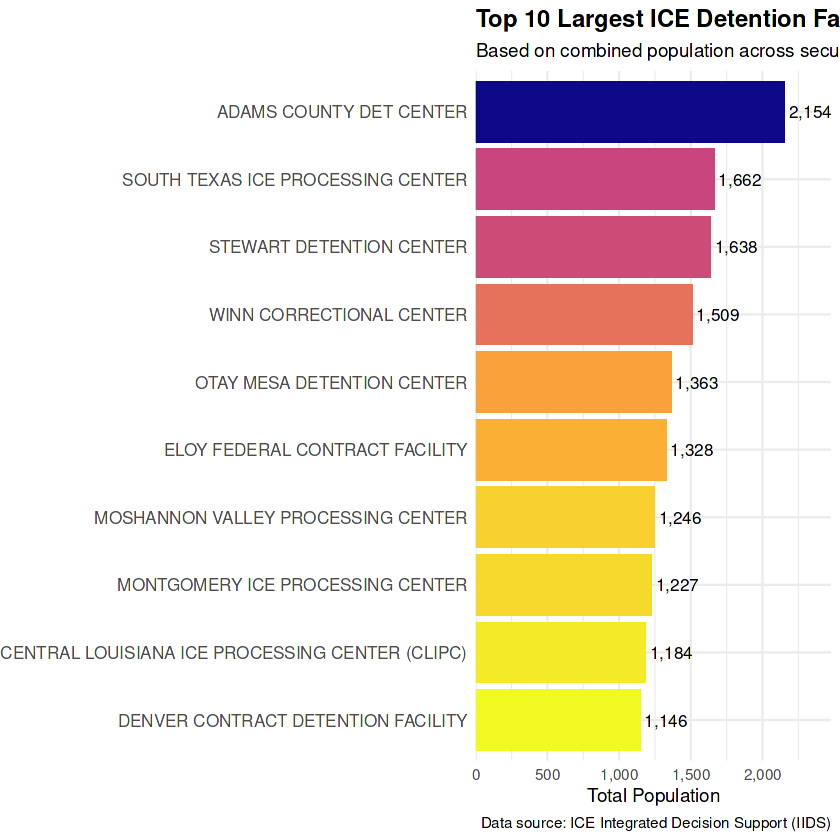

In [13]:
# Create an enhanced bar chart of the top 10 facilities
top_10_plot <- ggplot(top_10_facilities, aes(x = Total_Population, y = reorder(Name, Total_Population))) +
  geom_col(aes(fill = Total_Population)) +  # Color gradient by size
  geom_text(
    aes(label = comma(Total_Population, accuracy = 1)),  # Format numbers with commas
    hjust = -0.1,  # Position labels to the right of bars
    size = 3.5,    # Text size
    color = "black" # Ensure text is readable
  ) + 
  scale_fill_viridis_c(option = "plasma", direction = -1) +  # Use viridis color palette for accessibility
  scale_x_continuous(
    expand = expansion(mult = c(0, 0.15)),  # Add space for labels
    labels = comma  # Add commas to axis labels
  ) +
  labs(
    title = "Top 10 Largest ICE Detention Facilities by Total Population",
    subtitle = "Based on combined population across security levels A, B, C, and D",
    caption = "Data source: ICE Integrated Decision Support (IIDS)",
    x = "Total Population",
    y = NULL  # No y-axis label needed
  ) +
  theme_minimal() +  # Clean theme
  theme(
    axis.text.y = element_text(size = 10),  # Bigger y-axis text
    plot.title = element_text(face = "bold", size = 14),  # Bold title
    plot.subtitle = element_text(size = 11),  # Subtitle size
    legend.position = "none"  # Remove legend since it's redundant
  )

# Display the plot
print(top_10_plot)

# Save the plot as a PNG file
ggsave("top_10_facilities_visualization.png", plot = top_10_plot, width = 10, height = 6, dpi = 300)

### 4.2 Stacked Bar Chart Showing Population Levels

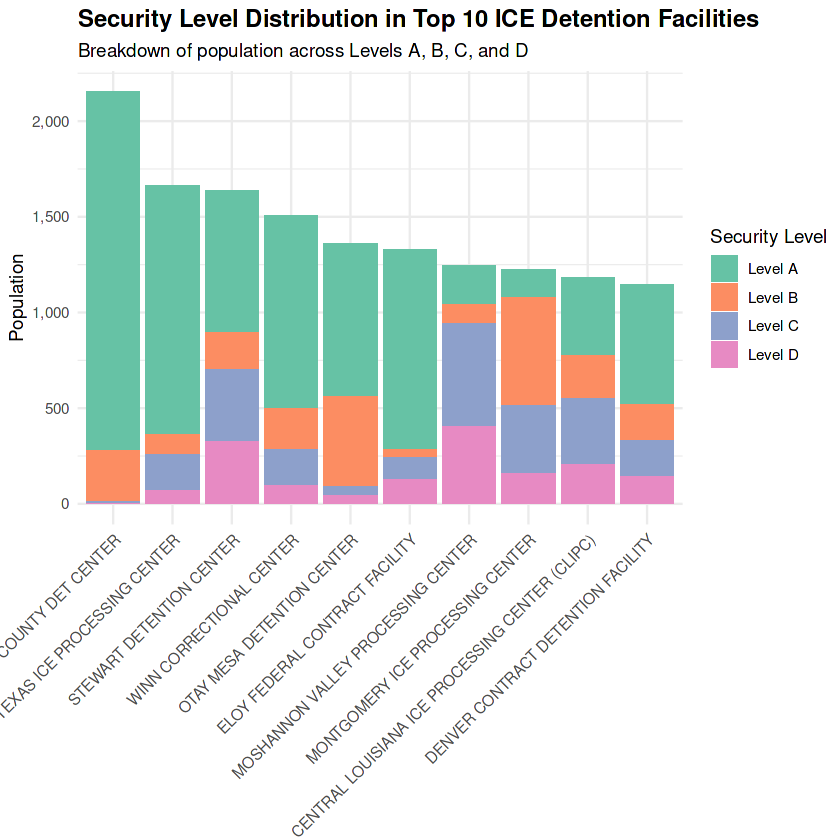

In [14]:
# Create a stacked bar chart showing the breakdown by security level
top_10_stacked <- top_10_facilities %>%
  pivot_longer(
    cols = starts_with("Level_"),
    names_to = "Security_Level",
    values_to = "Population"
  ) %>%
  mutate(
    Security_Level = factor(
      str_replace(Security_Level, "Level_", "Level "),
      levels = c("Level A", "Level B", "Level C", "Level D")
    )
  )

# Create the stacked bar plot
stacked_plot <- ggplot(top_10_stacked, 
                      aes(x = reorder(Name, -Population, sum), y = Population, fill = Security_Level)) +
  geom_col() +
  scale_fill_brewer(palette = "Set2") +
  scale_y_continuous(labels = comma) +
  labs(
    title = "Security Level Distribution in Top 10 ICE Detention Facilities",
    subtitle = "Breakdown of population across Levels A, B, C, and D",
    x = NULL,
    y = "Population",
    fill = "Security Level"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 9),
    legend.position = "right",
    plot.title = element_text(face = "bold", size = 14)
  )

print(stacked_plot)
ggsave("security_level_distribution.png", plot = stacked_plot, width = 10, height = 6, dpi = 300)

### 4.3 Geographic Distribution Analysis

[1] "Top 10 States by Detention Population:"




|State | Facility_Count| Total_Population| Avg_Population| Max_Population|
|:-----|--------------:|----------------:|--------------:|--------------:|
|TX    |             23|         12202.70|       12202.70|       12202.70|
|LA    |              9|          7026.58|        7026.58|        7026.58|
|CA    |              6|          3082.36|        3082.36|        3082.36|
|GA    |              5|          2551.83|        2551.83|        2551.83|
|AZ    |              5|          2309.72|        2309.72|        2309.72|
|MS    |              2|          2170.12|        2170.12|        2170.12|
|FL    |              9|          1690.08|        1690.08|        1690.08|
|PA    |              5|          1528.84|        1528.84|        1528.84|
|NM    |              3|          1374.58|        1374.58|        1374.58|
|CO    |              1|          1146.11|        1146.11|        1146.11|

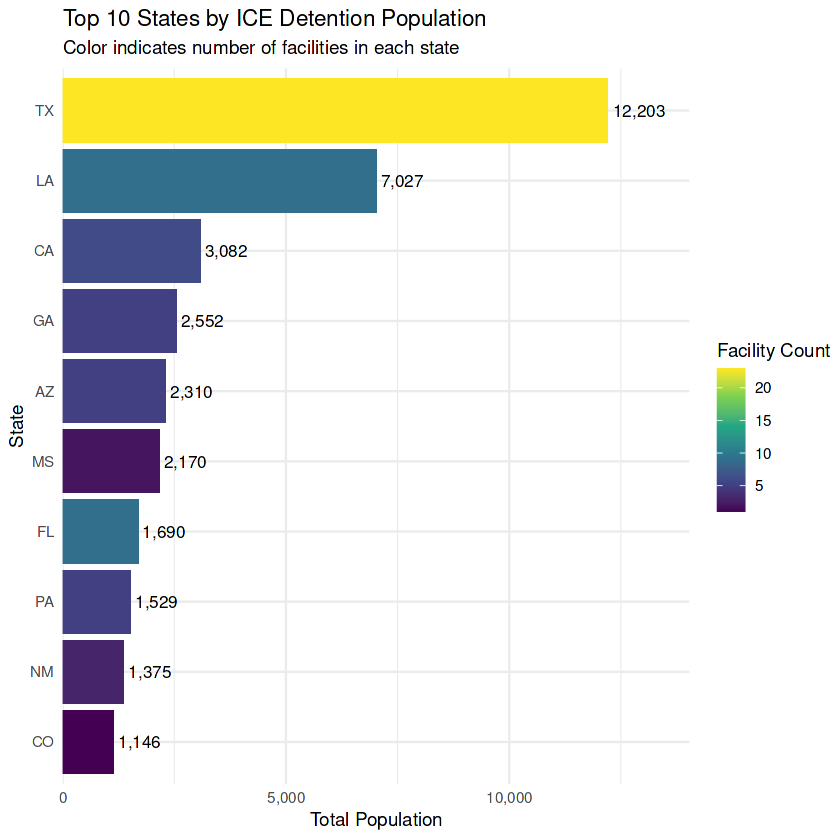

In [15]:
# Calculate total detention population by state
state_population <- analyzed_data %>%
  filter(!is.na(State) & State != "") %>%  # Remove rows with missing states
  group_by(State) %>%
  summarise(
    Facility_Count = n(),
    Total_Population = sum(Total_Population),
    Avg_Population = mean(Total_Population),
    Max_Population = max(Total_Population)
  ) %>%
  arrange(desc(Total_Population))

# Display the top 10 states by total population
print("Top 10 States by Detention Population:")
knitr::kable(head(state_population, 10), digits = 2)

# Create a bar chart of the top 10 states
top_states_plot <- ggplot(head(state_population, 10), 
                         aes(x = Total_Population, y = reorder(State, Total_Population))) +
  geom_col(aes(fill = Facility_Count)) +
  geom_text(
    aes(label = comma(Total_Population, accuracy = 1)),
    hjust = -0.1,
    size = 3.5
  ) +
  scale_x_continuous(expand = expansion(mult = c(0, 0.15)), labels = comma) +
  scale_fill_viridis_c(option = "viridis") +
  labs(
    title = "Top 10 States by ICE Detention Population",
    subtitle = "Color indicates number of facilities in each state",
    x = "Total Population",
    y = "State",
    fill = "Facility Count"
  ) +
  theme_minimal()

print(top_states_plot)
ggsave("top_states_by_population.png", plot = top_states_plot, width = 10, height = 6, dpi = 300)

## Part 5: Anomaly and Pattern Analysis

### 5.1 Population Distribution Across Security Levels

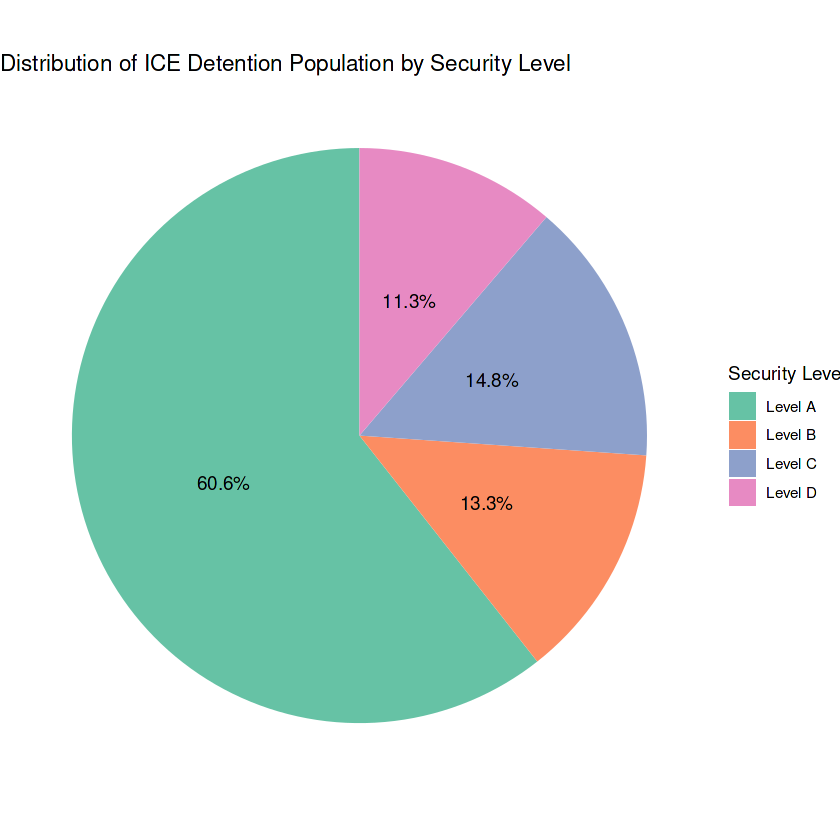

In [16]:
# Calculate the overall distribution of detainees by security level
level_distribution <- analyzed_data %>%
  summarise(
    Level_A_Total = sum(Level_A),
    Level_B_Total = sum(Level_B),
    Level_C_Total = sum(Level_C),
    Level_D_Total = sum(Level_D),
    Total = sum(Total_Population)
  ) %>%
  pivot_longer(
    cols = starts_with("Level_"),
    names_to = "Security_Level",
    values_to = "Population"
  ) %>%
  mutate(
    Security_Level = str_replace(Security_Level, "_Total", ""),
    Percentage = Population / Total * 100,
    Security_Level = factor(
      str_replace(Security_Level, "Level_", "Level "),
      levels = c("Level A", "Level B", "Level C", "Level D")
    )
  )

# Create a pie chart of the security level distribution
pie_chart <- ggplot(level_distribution, aes(x = "", y = Percentage, fill = Security_Level)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  geom_text(aes(label = paste0(round(Percentage, 1), "%")), 
            position = position_stack(vjust = 0.5)) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Distribution of ICE Detention Population by Security Level",
    fill = "Security Level"
  ) +
  theme_void() +
  theme(legend.position = "right")

print(pie_chart)

### 5.2 Inspection Date Analysis

[1] "Distribution of inspections by year:"
# A tibble: 4 × 2
  Inspection_Year     n
            <dbl> <int>
1            2021     2
2            2023     3
3            2024    80
4            2025    32


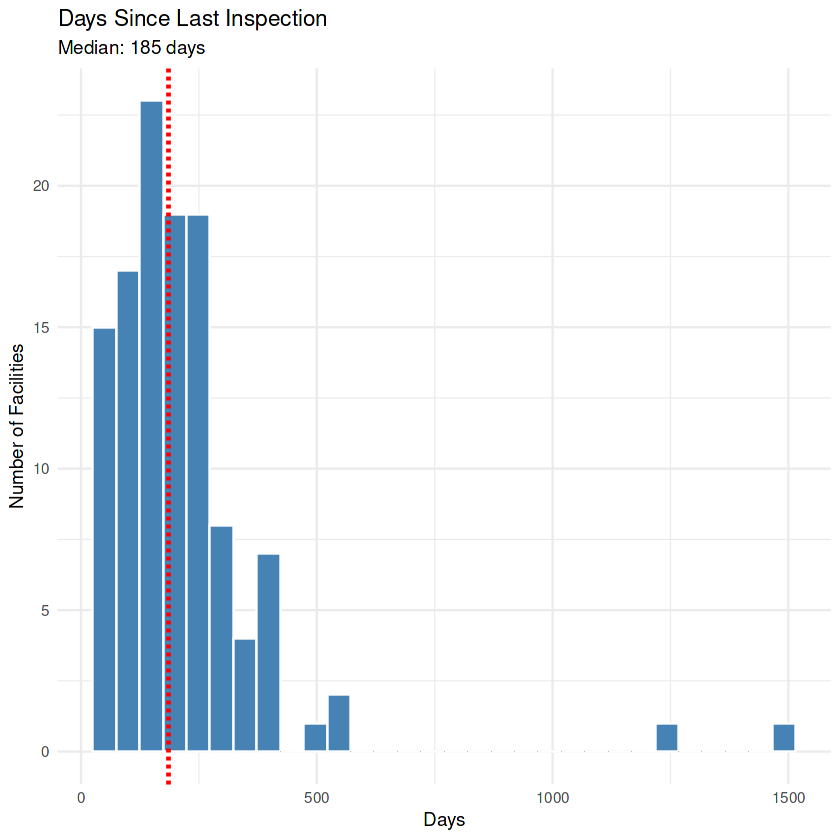

In [17]:
# Analyze inspection dates
inspection_analysis <- analyzed_data %>%
  filter(!is.na(Last_Inspection_Date_Parsed)) %>%
  mutate(
    Inspection_Year = year(Last_Inspection_Date_Parsed),
    Inspection_Month = month(Last_Inspection_Date_Parsed),
    Days_Since_Inspection = as.numeric(Sys.Date() - Last_Inspection_Date_Parsed)
  )

# Inspection year distribution
year_distribution <- inspection_analysis %>%
  count(Inspection_Year) %>%
  arrange(Inspection_Year)

print("Distribution of inspections by year:")
print(year_distribution)

# Create a visualization of days since inspection
days_since_plot <- ggplot(inspection_analysis, aes(x = Days_Since_Inspection)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  geom_vline(aes(xintercept = median(Days_Since_Inspection)), 
             color = "red", linetype = "dashed", linewidth = 1) +
  labs(
    title = "Days Since Last Inspection",
    subtitle = paste0("Median: ", round(median(inspection_analysis$Days_Since_Inspection)), " days"),
    x = "Days",
    y = "Number of Facilities"
  ) +
  theme_minimal()

print(days_since_plot)

## Conclusion and Final Dataset

In this analysis, we've successfully:

1. **Cleaned a messy detention facility dataset**, addressing issues like:
   - Special characters and inconsistencies in facility names
   - Missing or incorrect city/state information
   - Scientific notation and formatting issues in numeric data
   - Mixed date formats

2. **Calculated total populations** by summing across security levels A through D

3. **Identified the top 10 largest facilities** and analyzed their characteristics

4. **Created visualizations** to effectively communicate findings, including:
   - Bar charts of top facilities ranked by population
   - Stacked bars showing security level distribution
   - Geographic analysis by state
   - Population distribution by security level
   - Inspection date patterns

5. **Detected potential data quality issues**, including outliers and anomalies

Let's save our cleaned and analyzed dataset for further use:

In [18]:
# Save the cleaned dataset
write_csv(analyzed_data, "cleaned_ice_detention_data.csv")
print("Cleaned data saved to cleaned_ice_detention_data.csv")

# Summary of data quality improvements
print(paste0("Initial rows: ", nrow(raw_data)))
print(paste0("Final rows: ", nrow(analyzed_data)))
print(paste0("Missing names fixed: ", sum(is.na(raw_data$Name)) - sum(is.na(analyzed_data$Name))))
print(paste0("Missing states fixed: ", sum(is.na(raw_data$State)) - sum(is.na(analyzed_data$State))))
print(paste0("Dates successfully parsed: ", sum(!is.na(analyzed_data$Last_Inspection_Date_Parsed)) / 
                                           sum(!is.na(analyzed_data$Last_Inspection_Date)) * 100, "%"))

[1] "Cleaned data saved to cleaned_ice_detention_data.csv"
[1] "Initial rows: 134"
[1] "Final rows: 134"
[1] "Missing names fixed: 2"
[1] "Missing states fixed: 2"
[1] "Dates successfully parsed: 100%"
